In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
#import pandas_profiling
%matplotlib inline

In [29]:
train_ = pd.read_csv('./data/train.csv',index_col=0)
train_md_ = pd.read_csv('./data/train_modified.csv',index_col=0)
test_ = pd. read_csv('./data/test.csv',index_col=0)
sample_submission = pd.read_csv('./data/sample_submission.csv', index_col=0)

데이터 설명

-     대전지역에서 측정한 실내외 19곳의 센서데이터와, 주변 지역의 기상청 공공데이터를 semi-비식별화하여 제공합니다. 
-     센서는 온도를 측정하였습니다. 
-     모든 데이터는 시간 순으로 정렬 되어 있으며 10분 단위 데이터 입니다. 
-     예측 대상(target variable)은 Y18입니다. 

train.csv 

-     30일 간의 기상청 데이터 (X00 ~ X39) 및 센서데이터 (Y00~Y17)
-     이후 3일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y18)

test.csv 
-     train.csv 기간 이후 80일 간의 기상청 데이터 (X00~X39)

sample_submission.csv
-     제출 양식 예시

X00 X07 X28 X31 기온  
X01 X06 X22 X27 기압  
X02 X03 X18 X24 풍속  
X04 X10 X21 X36 누적강수량  
X05 X08 X09 X23 해면기압  
X11 X14 X16 X19 누적일사량  
X12, X20, X30, X37 습도
X13 X15 X17 X25 풍향  

Y00~17 센서측정온도  

In [30]:
train=train_.copy()
train_md=train_md_.copy()
test=test_.copy()

In [31]:
# try:
#     del train['X14']
#     del train['X16']
#     del train['X19']
# except:
#     pass

### Y00 ~ Y17 >>> [0:4320]: Value, [4321:]: NaN, Y_index: [41:58]
### Y18 >>> [0:4320]: NaN, [4321:]: Value, Y_index: [59]

In [32]:
base=train_md.iloc[:,:]

In [33]:
x1=base.iloc[4320:,:-1]
y1=base.iloc[4320:,-1]

In [34]:
x_te=base.iloc[:4320,:-1]

In [35]:
# try:
#     del la['Y00']
#     del la['Y03']
#     del la['Y04']
#     del la['Y13']
#     del la['Y14']
# except:
#     pass

In [36]:
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

x_train, x_test, y_train, y_test = train_test_split(x1,y1, train_size=0.7, shuffle=False) #random_state=0)

In [52]:
x_train.shape, x_test.shape

((302, 58), (130, 58))

In [37]:
import catboost as cb

import warnings
warnings.filterwarnings(action='ignore')

In [156]:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import r2_score, mean_squared_error

# params={ 'max_depth':8, 'n_estimators':1200,  'learning_rate': 0.008, \
#     'boost_from_average': False, 'subsample': 0.8, \
#     'coal_sample_bytree':0.8, 'gamma':0.1, 'num_leaves':256, \
#     'feature_fraction':0.2,'bagging_fraction':0.40,'reg_alpha': 0.012, 'reg_lambda':0.012,}

params={ 'max_depth':5, 'n_estimators':1600,  'learning_rate': 0.009, \
        'boost_from_average': False, 'subsample': 0.80, \
        'coal_sample_bytree':0.75, 'gamma':0.2, 'num_leaves':256, \
        'feature_fraction':0.2,'bagging_fraction':0.40,'lambda_l1': 0.16, \
        'lambda_l2':0.17,}

#clf= xgb.XGBRegressor(**params,verbose=200)
clf= lgbm.LGBMRegressor(**params, verbose=200)


# params={ 'max_depth':9, 'n_estimators':2500,  'learning_rate': 0.019, \
#        'boost_from_average': False, 'subsample': 0.75}

#clf= cb.CatBoostRegressor(**params,verbose=200,eval_metric='RMSE')

#multi_clf=MultiOutputRegressor(xgb.XGBRegressor())

# clf=MultiOutputRegressor(RandomForestRegressor())

model=clf.fit(x_train,y_train)

In [157]:
y_pred=model.predict(x_test)

In [158]:
r2sc=r2_score(y_pred,y_test)
print(r2sc)

0.8833837434711732


In [159]:
y2=model.predict(x2)

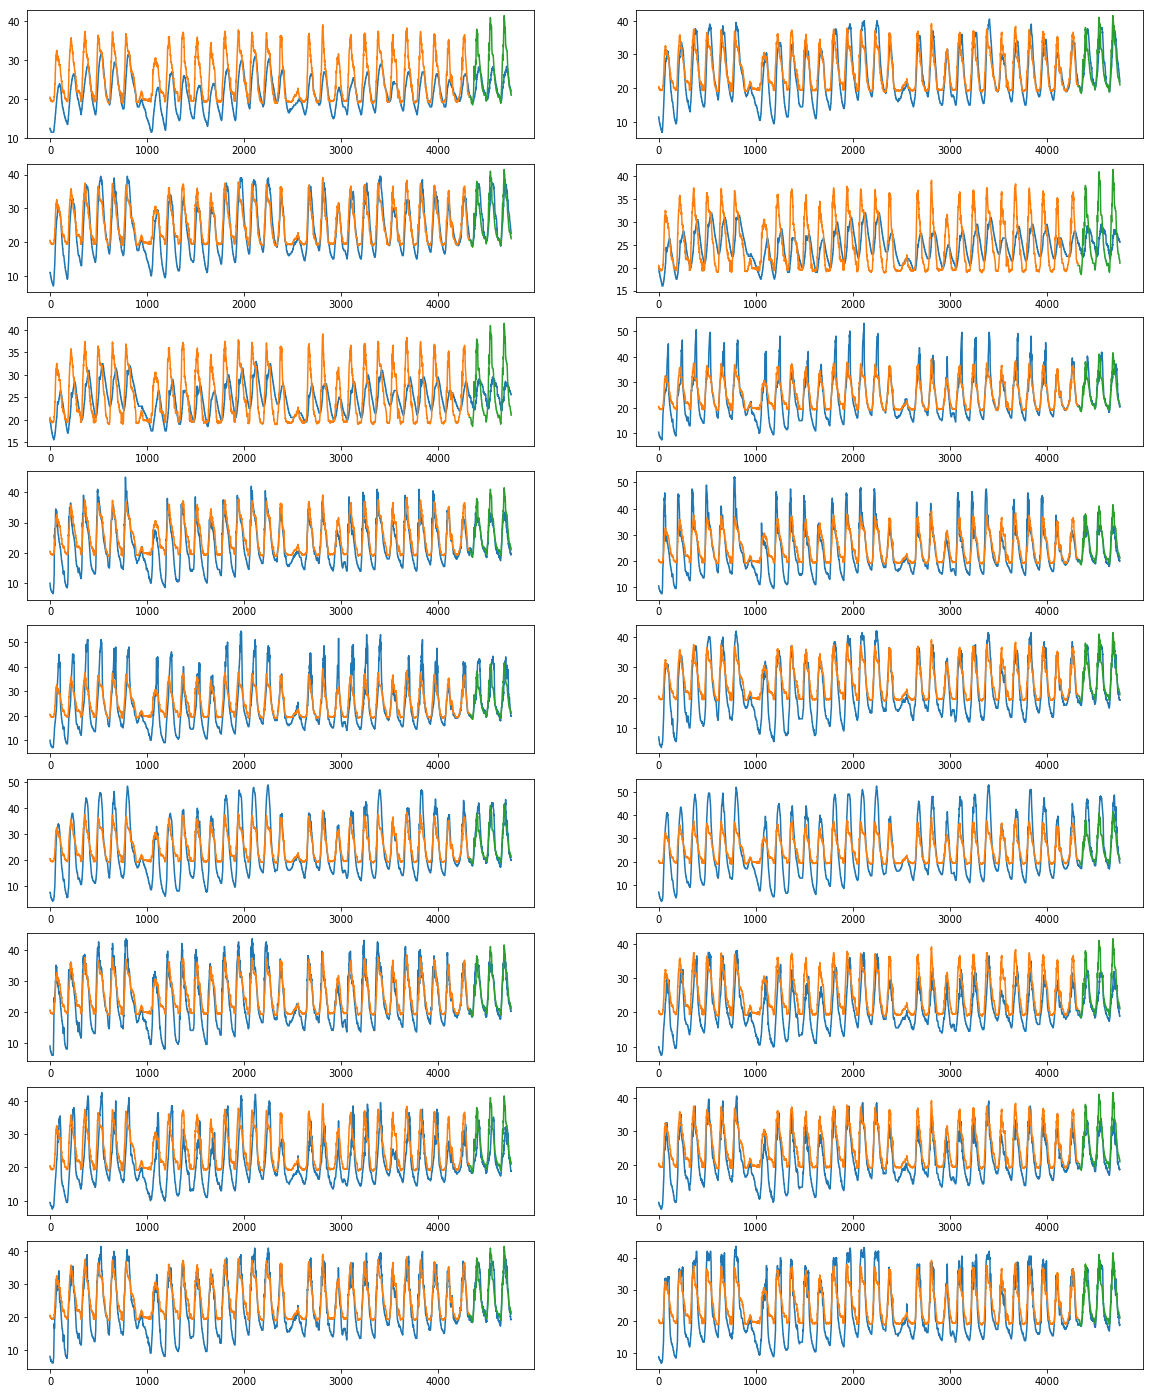

In [160]:
plt.figure(figsize=(20,25))

col=base.iloc[:,40:-1].columns

for i,co in enumerate(col):
    plt.subplot(9,2,i+1)
    plt.plot(base[co])
    plt.plot(y2)
    plt.plot(y1)

In [105]:
xp=train_.iloc[:,:40]
yp=train_.iloc[:,-1]

In [110]:
yp[0:4320]=y2

In [117]:
clf= xgb.XGBRegressor(**params,verbose=200)
models=clf.fit(xp,yp)

[12:56:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [118]:
res=models.predict(test_x)

In [120]:
submission = pd.DataFrame(data=res, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submission.csv', index=True)